الف) این فرمت که به نام سیستم ورودی خطی ساده شده شناخته میشود برای ترجمه ساختار سه بعدی یک ماده شیمیایی به رشته ای از نمادها استفاده میشود که قابل درک است که برای وارد کردن ساختار شیمیایی در برنامه های تخمین استفاده میشود.در این ساختار اتم ها، پیوندها با کاراکترهای خاصی نشان داده میشوند. برای نشان دادن آن از علائم هر اتم استفاده میشود. اگر پیوند بین دو عنصر یک پیوند ساده باشد عناصر پشت سر هم نوشته میشوند ولی اگر نوع پیوند فرق کند و مثلا دوتایی شود از علامتی مانند = استفاده میشود. پرانتزها نشان دهنده شاخه های عنصر هستند. برای شمارش تعداد کاراکترها باید تعداد عناصر به کار رفته در فرمول را بررسی کنیم که چند تا است  و این کار باید روی کل مجموعه انجام شود.باید توجه داشت که توزیع طول زنجیره یکسان نیست. همانطور که گفته شد رشته های آن شامل اتم، عنصر و نوع پیوند است که رایج ترین اتم های آن کربن، اکسیژن، هیدروژن و نیتروژن است و پیوندهای آن پیوندهای تک، دوگانه و آروماتیک است و کاراکترهای پرانتز، براکت، و نقطه برای نمایشهای ساختار به کار میرود.  

In [2]:
import nltk
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset


The range of molecule formula lengths is from 3 to 400.


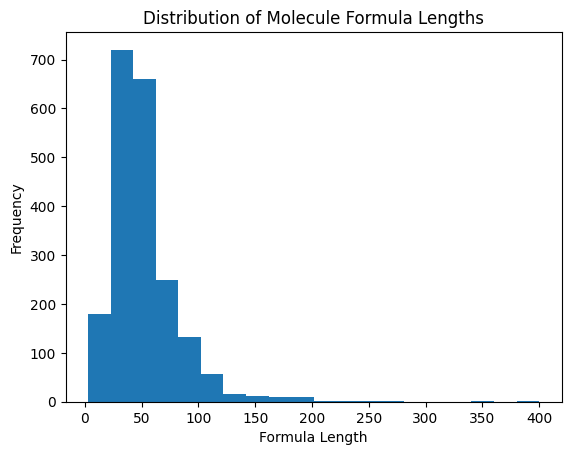

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Green.PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Token: [, Frequency: 3479
Token: Cl, Frequency: 446
Token: ], Frequency: 3479
Token: .CC, Frequency: 8
Token: (, Frequency: 10491
Token: C, Frequency: 7343
Token: ), Frequency: 10491
Token: NCC, Frequency: 35
Token: O, Frequency: 1348
Token: COc1cccc2ccccc12, Frequency: 2
Token: =O, Frequency: 2504
Token: OC, Frequency: 445
Token: CCCc1ccc, Frequency: 2
Token: cc1, Frequency: 80
Token: N, Frequency: 822
Token: CCCl, Frequency: 13
Token: c12c3c, Frequency: 2
Token: N4CCN, Frequency: 14
Token: CC4, Frequency: 100
Token: c, Frequency: 176
Token: F, Frequency: 457
Token: cc1c, Frequency: 1
Token: cn2C, Frequency: 1
Token: CO3, Frequency: 2
Token: C1CCN, Frequency: 5
Token: CC1, Frequency: 162
Token: Cc1cccc, Frequency: 9
Token: c1, Frequency: 105
Token: OCCCNC, Frequency: 3
Token: Cc1onc, Frequency: 5
Token: c2ccccc2Cl, Frequency: 3
Token: c1C, Frequency: 12
Token: @, Frequency: 4194
Token: H, Frequency: 2251
Token: 3, Frequency: 141
Token: 4SC, Frequency: 3
Token: N4C3=O, Frequency: 3
Tok

In [3]:
#PART A
#loading dataset
data = pd.read_csv("E:/M.SC/TERM3/Deep/Hw/Q1 Materials/BBBP.csv")

#finding the range of dataset with min and max
data['smiles_length'] = data['smiles'].apply(len)

min_length = data['smiles_length'].min()
max_length = data['smiles_length'].max()

print(f"The range of molecule formula lengths is from {min_length} to {max_length}.")

#finding distribution with histogrm
plt.hist(data['smiles_length'], bins=20)
plt.xlabel('Formula Length')
plt.ylabel('Frequency')
plt.title('Distribution of Molecule Formula Lengths')
plt.show()

nltk.download('punkt')

#finding tokens and frequency each of them
field = 'smiles'

tokenized_text = data[field].apply(nltk.word_tokenize)
flat_tokens = [token for sublist in tokenized_text for token in sublist]

freq_dist = FreqDist(flat_tokens)

for token, frequency in freq_dist.items():
    print(f"Token: {token}, Frequency: {frequency}")
    

In [15]:
#PART B
#encoding the characters using one-hot-encoder
smiles_list = data['smiles'].tolist()
labels = data['p_np'].values
vocabulary = sorted(set(''.join(smiles_list)))

char_to_index = {char: index for index, char in enumerate(vocabulary)}

encoded_smiles_list = []
for smiles in smiles_list:
    encoded_smiles = np.zeros(len(vocabulary))
    for char in smiles:
        encoded_smiles[char_to_index[char]] = 1
    encoded_smiles_list.append(encoded_smiles)
    
encoded_smiles_list = np.array(encoded_smiles_list)
encoded_labels = LabelEncoder().fit_transform(labels)

#seprating the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, encoded_labels, test_size=0.2)

#transforming data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

#defining a custom dataset
class SMILESDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

#creating data loaders
batch_size = 16
hidden_size = 29
num_classes = 2
num_epochs = 200

train_dataset = SMILESDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#defining the FC net
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = nn.functional.softmax(out, dim=1)
        return out

#creating the model instance
input_size = X_train.shape[1]

model = FCNet(input_size, hidden_size, num_classes)

#defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#training loop
accuracy_history = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Calculate accuracy on test data
with torch.no_grad():
    model.eval()
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    accuracy_history.append(accuracy)
    print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8219512195121951


In [17]:
#part C
#defining the LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #init parameters
        self.W_ih = nn.Parameter(torch.Tensor(input_size, hidden_size*4))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size*4))
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size*4))
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size*4))

        #out layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        #init weights
        nn.init.xavier_uniform_(self.W_ih)
        nn.init.orthogonal_(self.W_hh)
        nn.init.zeros_(self.b_ih)
        nn.init.zeros_(self.b_hh)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        #init hidden and cell states
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        #iterating to calculate c and h
        for t in range(seq_len):
            input_t = x[:, t, :]

            gates = torch.matmul(input_t, self.W_ih) + torch.matmul(h[-1, :, :], self.W_hh) + self.b_ih + self.b_hh
            i, f, g, o = gates.chunk(4, dim=1)

            c_t = torch.sigmoid(f) * c[-1, :, :] + torch.sigmoid(i) * torch.tanh(g)
            h_t = torch.sigmoid(o) * torch.tanh(c_t)

            c = torch.cat((c, c_t.unsqueeze(0)), dim=0)
            h = torch.cat((h, h_t.unsqueeze(0)), dim=0)

        #calculating output
        output = self.fc(h[-1, :, :])

        return output


#defining hyperparameters
input_size = X_train.shape[1]
hidden_size = 29
num_layers = 2
num_classes = 2
batch_size = 16
num_epochs = 200
learning_rate = 0.001

#creating the model
model = LSTM(input_size, hidden_size, num_layers, num_classes)

#defining the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#creating the data loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#training loop
total_correct = 0
total_examples = 0

for epoch in range(num_epochs):
    inputs = X_train.unsqueeze(1)
    targets_one_hot = F.one_hot(y_train, num_classes=2).float()

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_one_hot)
    loss.backward()
    optimizer.step()

    predicted_labels = (torch.sigmoid(outputs) >= 0.5).int()
    correct_batch = (predicted_labels == targets_one_hot.int()).all(dim=1).sum().item()
    total_correct += correct_batch
    total_examples += batch_size

    accuracy = total_correct / total_examples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {accuracy}")

model.eval()
with torch.no_grad():
    test_inputs = X_test.unsqueeze(1)
    predictions = model(test_inputs)
    predictions = (torch.sigmoid(predictions) >= 0.5).int()
    predictions = predictions.argmax(dim=1) 
    accuracy = (predictions == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy}")

Epoch [1/200], Loss: 0.6561393141746521, Training Accuracy: 78.3125
Epoch [2/200], Loss: 0.6541411876678467, Training Accuracy: 78.3125
Epoch [3/200], Loss: 0.6521756649017334, Training Accuracy: 78.3125
Epoch [4/200], Loss: 0.6502414345741272, Training Accuracy: 78.3125
Epoch [5/200], Loss: 0.6483350992202759, Training Accuracy: 78.3125
Epoch [6/200], Loss: 0.6464513540267944, Training Accuracy: 78.3125
Epoch [7/200], Loss: 0.6445850133895874, Training Accuracy: 78.3125
Epoch [8/200], Loss: 0.6427316069602966, Training Accuracy: 78.3125
Epoch [9/200], Loss: 0.6408871412277222, Training Accuracy: 78.3125
Epoch [10/200], Loss: 0.6390485167503357, Training Accuracy: 78.3125
Epoch [11/200], Loss: 0.6372126936912537, Training Accuracy: 78.3125
Epoch [12/200], Loss: 0.6353774070739746, Training Accuracy: 78.3125
Epoch [13/200], Loss: 0.6335403323173523, Training Accuracy: 78.3125
Epoch [14/200], Loss: 0.6316995024681091, Training Accuracy: 78.3125
Epoch [15/200], Loss: 0.6298531889915466, T

In [20]:
#Part D
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

# Defining hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 3
output_size = 2
batch_size = 32
num_epochs = 100
learning_rate = 0.0001

# Creating the model
model = BiLSTM(input_size, hidden_size, num_layers, output_size)

# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Creating the data loaders
train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
total_correct = 0
total_examples = 0

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        _, predicted_labels = torch.max(outputs, 1)
        correct_batch = (predicted_labels == targets).sum().item()
        total_correct += correct_batch
        total_examples += batch_size

    accuracy = total_correct / total_examples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Training Accuracy: {accuracy}")

model.eval()
with torch.no_grad():
    test_inputs = X_test.unsqueeze(1)
    predictions = model(test_inputs)
    _, predicted_labels = torch.max(predictions, 1)
    accuracy = (predicted_labels == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy}")

Epoch [1/100], Loss: 0.6370084881782532, Training Accuracy: 0.7530048076923077
Epoch [2/100], Loss: 0.6733625531196594, Training Accuracy: 0.7530048076923077
Epoch [3/100], Loss: 0.6682916283607483, Training Accuracy: 0.7530048076923077
Epoch [4/100], Loss: 0.5433916449546814, Training Accuracy: 0.7530048076923077
Epoch [5/100], Loss: 0.6596523523330688, Training Accuracy: 0.7530048076923077
Epoch [6/100], Loss: 0.37746116518974304, Training Accuracy: 0.7530048076923077
Epoch [7/100], Loss: 0.6414916515350342, Training Accuracy: 0.7530048076923077
Epoch [8/100], Loss: 0.312276691198349, Training Accuracy: 0.7538311298076923
Epoch [9/100], Loss: 0.7437139749526978, Training Accuracy: 0.7562767094017094
Epoch [10/100], Loss: 0.4301374554634094, Training Accuracy: 0.7611778846153846
Epoch [11/100], Loss: 0.12771815061569214, Training Accuracy: 0.7645323426573427
Epoch [12/100], Loss: 0.3706360161304474, Training Accuracy: 0.7676282051282052
Epoch [13/100], Loss: 0.23487843573093414, Train

In [21]:
#Part E
#using cross validation in part B:
print("##########################Cross validation for part B################################")
#defining the hyperparameters
batch_size = 32
hidden_size = 40
num_classes = 2
num_epochs = 100
num_folds = 40
learning_rate = 0.01

#a list to save the accuracies for each fold
accuracy_history = []

#performing cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True)
for fold, (train_indices, val_indices) in enumerate(kfold.split(encoded_smiles_list)):

    #separating the data
    X_train, X_val = encoded_smiles_list[train_indices], encoded_smiles_list[val_indices]
    y_train, y_val = encoded_labels[train_indices], encoded_labels[val_indices]

    #transforming the data to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()

    #defining the datasets and data loaders
    train_dataset = SMILESDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = SMILESDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #creating a new instance of the model for each fold
    input_size = X_train.shape[1]
    model = FCNet(input_size, hidden_size, num_classes)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluation on validation data
    with torch.no_grad():
        model.eval()
        total_correct = 0
        total_examples = 0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total_examples += targets.size(0)
        accuracy = total_correct / total_examples
    print(f"Fold [{fold + 1}/{num_folds}], Validation Accuracy: {accuracy}")

#using cross validation in part C:
print("######################Cross validation for part c##########################")

class SMILESDataset1(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        x = torch.unsqueeze(x, 0)
        y = self.labels[idx]
        return x, y
#defining the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #Initi parameters
        self.W_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 4))
        self.W_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 4))
        self.b_ih = nn.Parameter(torch.Tensor(hidden_size * 4))
        self.b_hh = nn.Parameter(torch.Tensor(hidden_size * 4))

        #Out layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        #init weights
        nn.init.xavier_uniform_(self.W_ih)
        nn.init.orthogonal_(self.W_hh)
        nn.init.zeros_(self.b_ih)
        nn.init.zeros_(self.b_hh)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        #init hidden and cell states
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        #iterating to calculate c and h
        for t in range(seq_len):
            input_t = x[:, t, :]

            gates = torch.matmul(input_t, self.W_ih) + torch.matmul(h[-1, :, :], self.W_hh) + self.b_ih + self.b_hh
            i, f, g, o = gates.chunk(4, dim=1)

            c_t = torch.sigmoid(f) * c[-1, :, :] + torch.sigmoid(i) * torch.tanh(g)
            h_t = torch.sigmoid(o) * torch.tanh(c_t)

            c = torch.cat((c, c_t.unsqueeze(0)), dim=0)
            h = torch.cat((h, h_t.unsqueeze(0)), dim=0)

        #calculate output
        output = self.fc(h[-1, :, :])

        return output

#defining the hyperparameters
hidden_size = 29
num_layers = 2
num_classes = 2
batch_size = 16
num_epochs = 200
learning_rate = 0.001
num_folds = 40

#a list to store the accuracies for each fold
accuracy_history = []

#performing cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True)
for fold, (train_indices, val_indices) in enumerate(kfold.split(encoded_smiles_list)):

    #separating the data
    X_train, X_val = encoded_smiles_list[train_indices], encoded_smiles_list[val_indices]
    y_train, y_val = encoded_labels[train_indices], encoded_labels[val_indices]

    #transforming the data to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).long()
    X_val = torch.from_numpy(X_val).float()
    y_val = torch.from_numpy(y_val).long()

    #creating data loaders
    train_dataset = SMILESDataset1(X_train, y_train)
    val_dataset = SMILESDataset1(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    #init the model
    model = LSTM(input_size=len(vocabulary), hidden_size=hidden_size, num_layers=num_layers, output_size=num_classes)

    #defining the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)

    print(f"Fold [{fold + 1}/{num_folds}], Validation Accuracy: {val_accuracy}")


##########################Cross validation for part B################################
Fold [1/40], Validation Accuracy: 0.7884615384615384
Fold [2/40], Validation Accuracy: 0.8269230769230769
Fold [3/40], Validation Accuracy: 0.8076923076923077
Fold [4/40], Validation Accuracy: 0.75
Fold [5/40], Validation Accuracy: 0.7884615384615384
Fold [6/40], Validation Accuracy: 0.8461538461538461
Fold [7/40], Validation Accuracy: 0.75
Fold [8/40], Validation Accuracy: 0.9038461538461539
Fold [9/40], Validation Accuracy: 0.8461538461538461
Fold [10/40], Validation Accuracy: 0.7884615384615384
Fold [11/40], Validation Accuracy: 0.9215686274509803
Fold [12/40], Validation Accuracy: 0.8627450980392157
Fold [13/40], Validation Accuracy: 0.8235294117647058
Fold [14/40], Validation Accuracy: 0.9019607843137255
Fold [15/40], Validation Accuracy: 0.9215686274509803
Fold [16/40], Validation Accuracy: 0.8627450980392157
Fold [17/40], Validation Accuracy: 0.8235294117647058
Fold [18/40], Validation Accuracy

و) این دیتا ست همانطور که گفته شد، مجموعه ای از ترکیبات شیمیایی است که دارای دو دسته نفوذ پذیر و نفوذ ناپذیر میباشد. دو شبکه نام برده شده شبکه های بازگشتی هستند که برای دیتاهای متوالی قابل استفاده اند. در شبکه دوم (بای ال اس تی ام) اطلاعات در زمان های متوالی (آینده به گذشته و گذشته به آینده) به هم ارتباط دارند و پردازش به صورت دو طرفه و متوالی است که به یک درک جامع تر منجر میشود. اما در شبکه اول (ال اس تی ام) فقط وابستگی گذشته به آینده وجود دارد و پردازش ها به صورت متوالی و یکطرفه انجام میشود. از طرفی نفوذ پذیری یا نفوذ ناپذیری ر این سلول ها، تحت تاثیر ترکیبات شیمیایی قبل و بعدی است که با توجه به معماری شبکه دوم این شبکه میتواند درک بهتری از این داشته باشد.  از طرفی به دلیل دسترسی این شبکه به دیتاهای مختلف در توالی های مختلف میتواند وابستگی های مختلف را درک کند و از آن استفاده کند که در شبکه اول این ممکن است نادیده گرفته شود و فقط به وابستگی های یک طرفه توجه گردد.

In [22]:
#part G
data = pd.read_csv("E:/M.SC/TERM3/Deep/Hw/Q1 Materials/BBBP.csv")

#finding the range of dataset with min and max
data['smiles_length'] = data['smiles'].apply(len)

#encoding the characters using one-hot-encoder
smiles_list = data['smiles'].tolist()
labels = data['p_np'].values
vocabulary = sorted(set(''.join(smiles_list)))

char_to_index = {char: index for index, char in enumerate(vocabulary)}

encoded_smiles_list = []
for smiles in smiles_list:
    encoded_smiles = np.zeros(len(vocabulary))
    for char in smiles:
        encoded_smiles[char_to_index[char]] = 1
    encoded_smiles_list.append(encoded_smiles)
    
encoded_smiles_list = np.array(encoded_smiles_list)
encoded_labels = LabelEncoder().fit_transform(labels)

#seprating the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(encoded_smiles_list, encoded_labels, test_size=0.2)

#transforming data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

#defining a custom dataset
class SMILESDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

#creating data loaders
batch_size = 32
hidden_size = 40
num_classes = 2
num_epochs = 100

train_dataset = SMILESDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#defining the FC net
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = nn.functional.softmax(out, dim=1)
        return out

#creating the model instance
input_size = X_train.shape[1]

model = FCNet(input_size, hidden_size, num_classes)

#defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#training loop
accuracy_history = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

#separating the data into 10 intervals
num_intervals = 10
interval_size = len(X_test) // num_intervals

#ecaluating accuracy 
for i in range(num_intervals):
    start_index = i * interval_size
    end_index = start_index + interval_size

    with torch.no_grad():
        model.eval()

        interval_inputs = X_test[start_index:end_index]
        interval_labels = y_test[start_index:end_index]

        interval_outputs = model(interval_inputs)
        _, interval_predicted = torch.max(interval_outputs, 1)
        interval_accuracy = (interval_predicted == interval_labels).sum().item() / len(interval_labels)

        print(f"Interval {i+1} - Accuracy: {interval_accuracy}")

Interval 1 - Accuracy: 0.8048780487804879
Interval 2 - Accuracy: 0.8536585365853658
Interval 3 - Accuracy: 0.8292682926829268
Interval 4 - Accuracy: 0.7560975609756098
Interval 5 - Accuracy: 0.8780487804878049
Interval 6 - Accuracy: 0.9024390243902439
Interval 7 - Accuracy: 0.9024390243902439
Interval 8 - Accuracy: 0.8536585365853658
Interval 9 - Accuracy: 0.8292682926829268
Interval 10 - Accuracy: 0.8536585365853658


همانطور که در نتیجه بالا نشخص است، در بازه های مختلف دقت افزایش یا کاهش پیدا کرده است که میتواند دلایل مختلفی داشته باشد. زمانی که ما دیتا را به بین های 10 تایی تقسیم میکنیم ما توجهی به توزیع این داده ها نداریم و این میتواند دقت شبکه را تغییر دهد. از طرفی به دلیل محدود بودن طول، شبکه نمیتواند کل پیچیدگی داده ها را درک کند و به همین دلیل درک درستی از پیچیدگی دیتا داشته باشد و به همین دلیل دقت تغییر میکند. 